In [4]:
import numpy as np
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from matplotlib import rc 

class SuttonReplicator():
    
    def __init__(self):
        

        self.states=["A","B","C","D","E","F","G"]
        self.terminal_states=["A","G"]
        self.number_of_states=len(self.states)
        self.w=np.array([0,0.5,0.5,0.5,0.5,0.5,0])
        self.__initialize_feature_vector__()
        np.random.seed(3)
        self.data_sets=self.construct_data_set()
        self.correct_weights=np.array([i/6 for i in range(1,6)])
        self.RMS=[]
        
    def rms(self):
        self.RMS.append(np.sqrt(mean_squared_error(self.correct_weights,self.w[1:6])))
        
    def reset_weight(self):
        self.w=np.array([0,0.5,0.5,0.5,0.5,0.5,0])
        
    def reset_all(self):
        self.w=np.array([0,0.5,0.5,0.5,0.5,0.5,0])
        self.RMS=[]
    
    def __initialize_feature_vector__(self):
        self.feature_vector={state:np.zeros(self.number_of_states) for state in self.states}
        for i,(key,value) in enumerate(self.feature_vector.items()):
            value[i]=1
            
    def __random_walk_sequence__(self):
        
        visited_states=[]
        current_index=3
        visited_states.append(self.states[current_index])
        while True:
            if current_index==6:
                return visited_states,1
            if current_index==0:
                return visited_states,0

            current_index+=np.random.choice([1,-1])
            visited_states.append(self.states[current_index])
            
    def __gereate_random_walk__(self):
        """
        Returns a list of lists representing events of a signle episode:
        [["initial state","next state","reward"],...]
        """
        states,reward=self.__random_walk_sequence__()
        state_reward=[]
        for i in range(len(states)-1):
            state_reward.append([states[i],states[i+1],0])
        state_reward[-1][-1]=reward
        return state_reward
    
    def get_feature_vector(self,state):
        return self.feature_vector[state]
    
    def construct_data_set(self,sequence_size=10,data_set_size=100):
        return [[self.__gereate_random_walk__() for i in range(sequence_size)] for j in range(data_set_size)]
    
    def delta_w_for_episode(self,episode,lmbda,alpha,repeated_representation=False):
        
        eligibility=np.zeros(self.number_of_states)
        delta_w=np.zeros(self.number_of_states)
        for current_state,next_state,reward in episode:
            error=reward+np.inner(self.w,self.get_feature_vector(next_state))-np.inner(self.w,self.get_feature_vector(current_state))
            eligibility=lmbda*eligibility+self.get_feature_vector(current_state)
            if repeated_representation:
                delta_w+=alpha*error*eligibility
            else:
                delta_w=alpha*error*eligibility
                self.w+=delta_w
        if repeated_representation:
            return delta_w

    def update_weights_repeated_presentation(self,data_sets,lmbda,alpha,convergence_threshold=0.01):
        
        for data_set in data_sets:
            self.reset_weight()
            converged=False
            while not converged:
                initial_w=deepcopy(self.w)
                delta_w=np.zeros(self.number_of_states)
                for episode in data_set:
                    delta_w+=self.delta_w_for_episode(episode,lmbda,alpha,repeated_representation=True)
                self.w+=delta_w
                converged=np.sum(np.abs(initial_w-self.w))<convergence_threshold
            self.rms()
             
    def update_weights_single_step_update(self,data_sets,lmbda,alpha,convergence_threshold=0.1):
        
        for data_set in data_sets:
            self.reset_weight()
            for episode in data_set:
                self.w+=self.delta_w_for_episode(episode,lmbda,alpha,repeated_representation=True)
            self.rms()
            
    def update_weights_normal(self,data_sets,lmbda,alpha,convergence_threshold=0.01): 
        count=0
        for data_set in data_sets:
            count+=1
            self.reset_weight()
            converged=False
            while not converged:
                initial_w=deepcopy(self.w)
                for episode in data_set:
                    self.w+=self.delta_w_for_episode(episode,lmbda,alpha,repeated_representation=True)
                converged=np.sum(np.abs(initial_w-self.w))<convergence_threshold
            self.rms()
        
    def unit_experiment_repeated_presentation(self,lmbda,alpha):
        self.update_weights_repeated_presentation(self.data_sets,lmbda,alpha)
        return np.mean(self.RMS)
    
    def unit_experiment_normal(self,lmbda,alpha):
        self.update_weights_normal(self.data_sets,lmbda,alpha)
        return np.mean(self.RMS)  
    
    def unit_experiment_single_step(self,lmbda,alpha):
        self.update_weights_single_step_update(self.data_sets,lmbda,alpha)
        return np.mean(self.RMS)
    

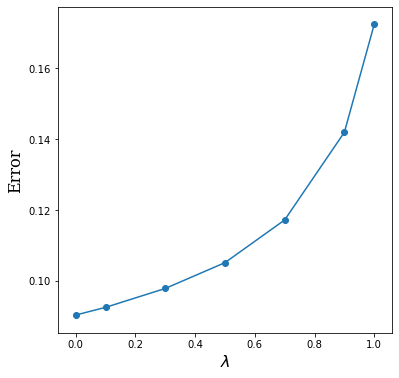

In [6]:
RMS=[]
font = {'family': 'serif',
        'weight': 'normal',
        'size': 16,
        }
lmbdas=[0,0.1,0.3,0.5,0.7,0.9,1]
cls=SuttonReplicator()
for lmbda in lmbdas:
    RMS.append(cls.unit_experiment_repeated_presentation(lmbda,0.01))
    cls.reset_all()
plt.figure(figsize=(6,6))

plt.xlabel('$\lambda$',fontsize=16,fontdict=font)
plt.ylabel('Error',fontsize=16,fontdict=font)
plt.plot(lmbdas,RMS)
plt.scatter(lmbdas,RMS);
plt.savefig("Figure3.eps",format="eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


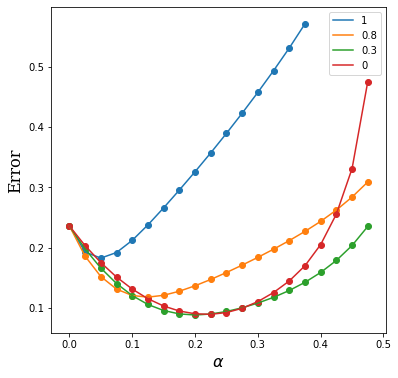

In [3]:
alphas={1:np.arange(0,0.4,0.025),0.8:np.arange(0,0.5,0.025),0.3:np.arange(0,0.5,0.025),0:np.arange(0,0.5,0.025)}
lmbdas=[1,0.8,0.3,0]
cls=SuttonReplicator()
plt.figure(figsize=(6,6))

for lmbda in lmbdas:
    RMS=[]
    for alpha in alphas[lmbda]:
        RMS.append(cls.unit_experiment_single_step(lmbda,alpha))
        cls.reset_all()
    plt.plot(alphas[lmbda],RMS,label=str(lmbda))
    plt.scatter(alphas[lmbda],RMS)
plt.xlabel(r'$\alpha$',fontsize=16,fontdict=font)
plt.ylabel('Error',fontsize=16,fontdict=font)
plt.legend();
plt.savefig("Figure4.eps",format="eps")

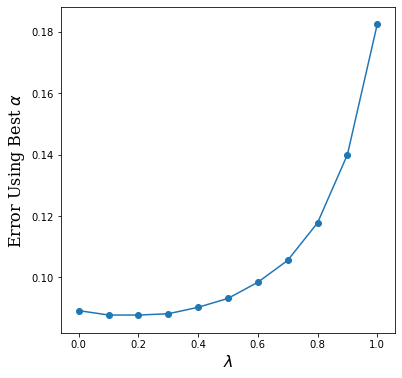

In [47]:
RMS=[]
lmbdas=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
alphas={0:0.22,0.1:0.22,0.2:0.22,0.3:0.2,0.4:0.18,0.5:0.175,0.6:0.15,0.7:0.14,0.8:0.12,0.9:0.1,1:0.05}
cls=SuttonReplicator()
for lmbda in lmbdas:
    RMS.append(cls.unit_experiment_single_step(lmbda,alphas[lmbda]))
    cls.reset_all()
plt.figure(figsize=(6,6))
plt.ylabel(r"Error Using Best $\alpha$",fontsize=16,fontdict=font)
plt.xlabel("$\lambda$",fontsize=16,fontdict=font)
plt.plot(lmbdas,RMS)
plt.scatter(lmbdas,RMS);
plt.savefig("Figure5.eps",format="eps")